In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
# import py4DSTEM
# from scipy import ndimage
# import gc

import time
import sys
sys.path.append('../XTEC/src/xtec')

from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
# from GMM import GMM
import re

import h5py
from skimage.feature import peak_local_max
from matplotlib.animation import FuncAnimation

## Load

In [2]:
# workingdir='../STEM_recal/'
# workingdir='/home/shared/STEM_recal/'
workingdir='/share/kim/STEM_sample_3/'
# workingdir='/home/shared/STEM_recal_2/'

In [3]:
f=h5py.File(workingdir+'data.hdf5','r')

In [4]:
I,T=f['I'],f['T']

In [5]:
I.shape

(20, 400, 180, 128, 128)

In [6]:
T.shape

(20,)

## Animation

In [9]:
%matplotlib widget

In [6]:
def generate_arc(center,radius,theta):
    i=np.cos(theta)*radius+center[0]
    j=np.sin(theta)*radius+center[1]
    return i,j

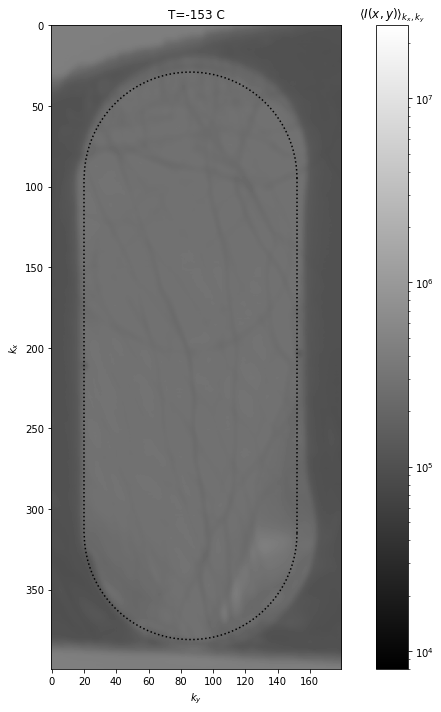

In [11]:
# data=I[0,:,:,I.shape[3]//2-10:I.shape[3]//2+10,I.shape[4]//2-10:I.shape[4]//2+10].mean(axis=(2,3))
data=I[5,:,:,:,:].mean(axis=(2,3))

# data=I[0,:,:,:,:].mean(axis=(0,1))

# mask=np.full(data.shape,True)
# mask[:,95:]=False
# data[~mask]=np.nan

fig,ax=plt.subplots(figsize=(10,10),tight_layout=True)
im=ax.imshow(data,cmap='gray', norm=colors.LogNorm(vmin=10**3.9, vmax=10**7.4))
tit=ax.set_title('T={:d} C'.format(T[0]))
cb=plt.colorbar(im,ax=ax)
cb.ax.set_title(r'$\langle I(x,y) \rangle_{k_x,k_y}$')
# cb.ax.set_title(r'$\langle I(k_x,k_y) \rangle_{x,y}$')

ax.set_xlabel(r'$k_y$')
ax.set_ylabel(r'$k_x$')
ax.set_aspect('equal')
# ax.plot([x],[y],'.r')

# mask=((120,160),(60,100))
# ax.plot(*np.array([[mask[1][0],mask[0][0]],[mask[1][1],mask[0][0]],[mask[1][1],mask[0][1]],[mask[1][0],mask[0][1]],[mask[1][0],mask[0][0]]]).T,color='k',lw=2)
# ax.plot([0,81],[178,199],color='k',ls='dotted')


# ax.axvline(x=20,color='k',ls='dotted')
# ax.axvline(x=152,color='k',ls='dotted')
# ax.axhline(y=95,color='k',ls='dotted')
# ax.axhline(y=315,color='k',ls='dotted')
ax.plot([20,20,],[95,315,],color='k',ls='dotted')
ax.plot([152,152,],[315,95,],color='k',ls='dotted')
y_1,x_1=generate_arc([(20+152)/2,95],(152-20)/2,np.linspace(0,-np.pi))
y_2,x_2=generate_arc([(20+152)/2,315],(152-20)/2,np.linspace(0,np.pi))
ax.plot(y_1,x_1,ls='dotted',color='k')
ax.plot(y_2,x_2,ls='dotted',color='k')

In [12]:
def animate(i):
    # data=I[i,:,:,I.shape[3]//2-10:I.shape[3]//2+10,I.shape[4]//2-10:I.shape[4]//2+10].mean(axis=(-2,-1))
    data=I[i,:,:,:,:].mean(axis=(2,3))

    # data=I[i,:,:,:,:].mean(axis=(0,1))
    # mask=np.full(data.shape,True)
    # mask[:,85:]=False
    # data[~mask]=np.nan
    
    im.set_array(data)
    tit.set_text('T={:d} C'.format(T[i]))
    return im,tit

In [13]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0],blit=True,repeat=True)
# anim.save('I_r_ave_3.mp4',dpi=600)
anim.save('I_r_ave_3.gif',dpi=100)
# anim.save('I_k_ave_3.mp4',dpi=600)
# anim.save('I_k_ave_3.gif',dpi=100)
# anim.save('I_k_ave_3_cropped.mp4',dpi=600)
# anim.save('I_k_ave_3_cropped.gif',dpi=600)

##### Homogeneous region

In [ ]:
from IPython import display

In [ ]:
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()    

In [88]:
def animate(i):
    data=I[i,:,:,I.shape[3]//2-10:I.shape[3]//2+10,I.shape[4]//2-10:I.shape[4]//2+10].mean(axis=(-2,-1))
    im.set_array(data)
    tit.set_text('T={:d} C'.format(T[i]))
    return im,tit

In [89]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0],blit=True,repeat=True)
anim.save('I_ave_cooling.mp4',dpi=600)

In [ ]:
def find_threshold_rel(data,err=.5,mask_target=None,min_distance=3):
    '''
    data should be rescaled by log10
    binary search the steepest point
    '''

    thres_=np.array([0,1.])  # min,max
    if mask_target is None:
        mask_target=np.array([peak_local_max(np.log10(data),threshold_rel=thres).shape[0] for thres in thres_]).mean()
    thres_middle=thres_.mean()
    mask_middle=peak_local_max(np.log10(data),threshold_rel=thres_middle,min_distance=3)
    while np.abs(mask_target-mask_middle.shape[0])>err:
        if mask_middle.shape[0]>mask_target:
            thres_[0]=thres_middle
        else:
            thres_[1]=thres_middle
        thres_middle=thres_.mean()
        mask_middle=peak_local_max(np.log10(data),threshold_rel=thres_middle,min_distance=3)
    return thres_middle,mask_middle,mask_target,


In [7]:
# x,y=75,125
x,y=100,100
T_idx=0
data=I[T_idx,x,y,:,:]


## Upscale (abandoned because it blurs the image)

In [ ]:
from scipy import interpolate

In [ ]:
x,y=100,100
T_idx=0
# data=I[T_idx,x,y,45:65,45:65]

In [ ]:
z=I[:,x,y,45:65,45:65].max(axis=(1,2))

In [ ]:
plt.plot(T[:-1],z[:-1])

In [ ]:
[np.where(I[i,x,y,45:65,45:65]==I[i,x,y,45:65,45:65].max()) for i in range(T.shape[0]-1)]

In [ ]:
I[:,x,y].max(axis=0)

In [ ]:
xmesh,ymesh=np.meshgrid(np.linspace(0,data.shape[0]-1,data.shape[0]),np.linspace(0,data.shape[1]-1,data.shape[1]))

In [ ]:
f = interpolate.interp2d(xmesh, ymesh, np.log10(data), kind='')

In [ ]:
xline_fine,yline_fine=np.linspace(0,data.shape[0]-1,data.shape[0]*5),np.linspace(0,data.shape[0]-1,data.shape[0]*5)

In [ ]:
zmesh_line=f(xline_fine,yline_fine)

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))


im=ax.pcolormesh(xline_fine,yline_fine,zmesh_line,cmap='gray')
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title('I')
# ax.scatter(55,55)

# ax.scatter(mask[:,1]+0.5,mask[:,0]+0.5,s=5,c='r')


## find peaks and visualize

In [27]:
x,y=190,0
T_idx=0
data=I[T_idx,x,y]

In [28]:
# thres,mask_ind,_=find_threshold_rel(data,min_distance=1)
mask_ind=peak_local_max(np.log10(data),threshold_rel=0,min_distance=3)
data_masked=data[tuple(mask_ind.T)]

Text(0, 0.5, '$k_y$')

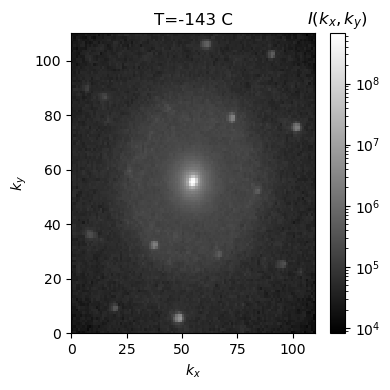

In [29]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)


# vmin,vmax=max(I[:,x,y].min(),1),I[:,x,y].max()
vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
# ax.scatter(55,55)

# ax.scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')
# ax.scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')

# ax.scatter(mask_ind_shift[0][[0,1],1]+.5,mask_ind_shift[0][[0,1],0]+.5,s=5,c='b')
# ax.scatter(mask_ind_shift[0][[19,147],1]+.5,mask_ind_shift[0][[19,147],0]+.5,s=5,c='y',alpha=0.4)

Text(0, 0.5, '$k_y$')

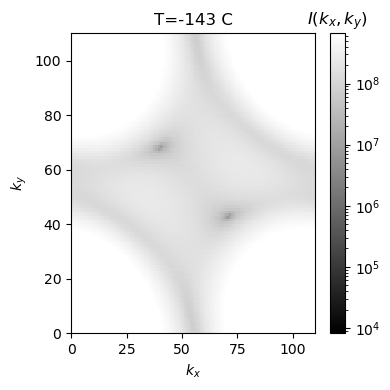

In [30]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)


# vmin,vmax=max(I[:,x,y].min(),1),I[:,x,y].max()
vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(np.abs(np.fft.fft2(data)),cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')




Text(0, 0.5, '$k_y$')

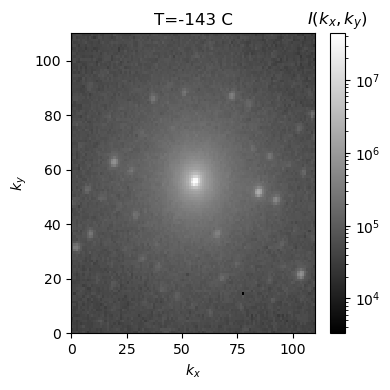

In [63]:
fig,ax=plt.subplots(figsize=(4,4),tight_layout=True)


# vmin,vmax=max(I[:,x,y].min(),1),I[:,x,y].max()
vmin,vmax=data.min(),data.max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$ I(k_x,k_y) $')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
# ax.scatter(55,55)

# ax.scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')
# ax.scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')

# ax.scatter(mask_ind_shift[0][[0,1],1]+.5,mask_ind_shift[0][[0,1],0]+.5,s=5,c='b')
# ax.scatter(mask_ind_shift[0][[19,147],1]+.5,mask_ind_shift[0][[19,147],0]+.5,s=5,c='y',alpha=0.4)

### Animation for all T

In [120]:
def animate(i):
    im.set_array(I[i,x,y])
    tit.set_text('T={:d} C'.format(T[i]))
    return im, 

In [121]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0],blit=True,repeat=True)
anim.save('I_ave_k_cooling.mp4',dpi=600)

### Distribution for all points

In [ ]:
fig,ax=plt.subplots()
ax.hist(np.log10(I[0,x,y]).flatten(),color='r',bins=np.linspace(4.5,7,21),alpha=.5)
# ax.hist(np.log10(I[-1,x,y]).flatten(),color='b',bins=np.linspace(4.5,7,21),alpha=.5)

In [ ]:
plt.hist(data_quantile.flatten(),color='y',bins=20,alpha=.5)

In [ ]:
plt.hist(data_zscore.flatten(),color='y',bins=20,alpha=.5)

## Shift

In [ ]:
center_list=([peak_local_max(I[T_idx,x,y,I.shape[3]//2-10:I.shape[3]//2+10,I.shape[4]//2-10:I.shape[4]//2+10],num_peaks=1)[0] for T_idx in range(T.shape[0])])

In [ ]:
offset_list=[center-center_list[0] for center in center_list]

## Quantile transformation

In [ ]:
from sklearn.preprocessing import quantile_transform

In [ ]:
x,y=199,199
T_idx=0
data=I[T_idx,x,y]

In [ ]:
mask_ind=peak_local_max(np.log10(data),threshold_rel=0.5,min_distance=3,p_norm=2)
data_masked=data[tuple(mask_ind.T)]

In [ ]:
np.log10(data_masked.min())/np.log10(data.max())

In [ ]:
data_flatten=data.reshape((-1,1))
data_quantile=quantile_transform(data_flatten,copy=True).reshape(data.shape)

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,8))


im=ax[0].pcolormesh(np.log10(data),cmap='gray', vmin=np.log10(data.min()),vmax=np.log10(data.max()))
tit=ax[0].set_title('T={:d} C'.format(T[T_idx]))
# cb=plt.colorbar(im)
# cb.ax.set_title('I')
# ax[0].scatter(55,55)

ax[1].pcolormesh(data_quantile,cmap='gray', vmin=data_quantile.min(),vmax=data_quantile.max())
ax[1].set_title('T={:d} C'.format(T[T_idx]))

ax[0].scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')
ax[0].scatter(mask_ind[:,1]+.5,mask_ind[:,0]+.5,s=5,c='r')
# ax[0].scatter(mask_ind_shift[0][[0,1],1]+.5,mask_ind_shift[0][[0,1],0]+.5,s=5,c='b')
# ax[0].scatter(mask_ind_shift[0][[19,147],1]+.5,mask_ind_shift[0][[19,147],0]+.5,s=5,c='y',alpha=0.4)



In [ ]:
zz=[data_quantile[tuple(idx)] for idx in mask_ind]

In [ ]:
plt.hist(zz)

## maxmin transformation

In [ ]:
from sklearn.preprocessing import minmax_scale

In [ ]:
T_idx=0
data=np.log10(I[T_idx,x,y])

In [ ]:
data_flatten=data.reshape((-1,1))
data_quantile=minmax_scale(data_flatten,copy=True).reshape(data.shape)

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,8))


im=ax[0].pcolormesh(np.log10(data),cmap='gray', vmin=np.log10(data.min()),vmax=np.log10(data.max()))
tit=ax[0].set_title('T={:d} C'.format(T[T_idx]))
# cb=plt.colorbar(im)
# cb.ax.set_title('I')
# ax[0].scatter(55,55)

ax[1].pcolormesh(data_quantile,cmap='gray', vmin=data_quantile.min(),vmax=data_quantile.max())
ax[1].set_title('T={:d} C'.format(T[T_idx]))

ax[0].scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')
ax[0].scatter(mask_ind[:,1]+.5,mask_ind[:,0]+.5,s=5,c='r')
# ax[0].scatter(mask_ind_shift[0][[0,1],1]+.5,mask_ind_shift[0][[0,1],0]+.5,s=5,c='b')
# ax[0].scatter(mask_ind_shift[0][[19,147],1]+.5,mask_ind_shift[0][[19,147],0]+.5,s=5,c='y',alpha=0.4)



## z-score

In [ ]:
data_log10=np.log10(data)
data_zscore=(data_log10-data_log10.mean())/data.std()

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,8))

T_idx=0
data=I[T_idx,x,y]
data_log10=np.log10(data)
im=ax[0].pcolormesh(data_log10,cmap='gray', vmin=np.log10(data.min()),vmax=np.log10(data.max()))
tit=ax[0].set_title('T={:d} C'.format(T[T_idx]))

data_zscore=(data_log10-data_log10.mean())/data_log10.std()
ax[1].pcolormesh(data_zscore,cmap='gray', vmin=data_zscore.min(),vmax=data_zscore.max())
ax[1].set_title('T={:d} C'.format(T[T_idx]))

# ax[0].scatter(mask_ind_shift[0][[0,1],1]+.5,mask_ind_shift[0][[0,1],0]+.5,s=5,c='b')
# ax[0].scatter(mask_ind_shift[0][[19,147],1]+.5,mask_ind_shift[0][[19,147],0]+.5,s=5,c='y',alpha=0.4)



In [ ]:
data_zscore

## shift and track

In [ ]:
mask_ind_shift=[mask_ind+offset for offset in offset_list]

In [ ]:
Data_ind=mask_ind_shift[0]

data_stack=np.log10(I[:,x,y])

data_stack=[quantile_transform(data_stack[T_idx].reshape((-1,1)),copy=True).reshape(data.shape) for T_idx in range(T.shape[0]-1)]

# data_stack=[minmax_scale(data_stack[T_idx].reshape((-1,1)),copy=True).reshape(data.shape) for T_idx in range(T.shape[0]-1)]

# data_stack=[(data_stack[T_idx]-data_stack[T_idx].mean())/data_stack[T_idx].std() for T_idx in range(T.shape[0]-1)]

Data_thresh=(np.array([data_stack[T_idx][tuple(idx.T)] for T_idx,idx in zip(range(T.shape[0]-1),mask_ind_shift)]))

# Data_thresh=(np.log10(np.array([I[T_idx,x,y][tuple(idx.T)] for T_idx,idx in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_idx,x+1,y][tuple(idx.T)] for T_idx,idx in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_idx,x-1,y][tuple(idx.T)] for T_idx,idx in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_idx,x,y+1][tuple(idx.T)] for T_idx,idx in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_idx,x,y-1][tuple(idx.T)] for T_idx,idx in zip(range(T.shape[0]-1),mask_ind_shift)])))/5

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,8))

T_idx=0
data=I[T_idx,x,y]
im=ax[0].pcolormesh(np.log10(data),cmap='gray', vmin=np.log10(data.min()),vmax=np.log10(data.max()))
tit=ax[0].set_title('T={:d} C'.format(T[T_idx]))

im2=ax[1].pcolormesh(data_stack[T_idx],cmap='gray', vmin=data_stack[T_idx].min(),vmax=data_stack[T_idx].max())
tit2=ax[1].set_title('T={:d} C'.format(T[T_idx]))


In [ ]:
def animate(i):
    im.set_array(np.log10(I[i,x,y]))
    im2.set_array(data_stack[i])
    tit.set_text('T={:d} C'.format(T[i]))
    tit2.set_text('T={:d} C'.format(T[i]))
    return im, im2

In [ ]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0]-1,blit=True,repeat=True)
anim.save('quantile_transformation.mp4',dpi=600)

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,8))

T_idx=10
data=I[T_idx,x,y]
im=ax[0].pcolormesh(np.log10(data),cmap='gray', vmin=np.log10(data.min()),vmax=np.log10(data.max()))
tit=ax[0].set_title('T={:d} C'.format(T[T_idx]))

im2=ax[1].pcolormesh(data_stack[T_idx],cmap='gray', vmin=data_stack[T_idx].min(),vmax=data_stack[T_idx].max())
tit2=ax[1].set_title('T={:d} C'.format(T[T_idx]))


## Test normality

In [ ]:
plt.hist(Data_thresh.flatten(),bins=20)

In [ ]:
data_post_thresh = Data_thresh
Rescaled_data = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(np.mean(data_post_thresh,axis=0)) 


In [ ]:
plt.hist(Rescaled_data.flatten(),bins=20)

In [ ]:
import scipy

In [ ]:
scipy.stats.kurtosistest(Rescaled_data.flatten())

In [ ]:
z=np.random.normal(size=(10000,))

In [ ]:
scipy.stats.kurtosistest(z)

## Transformation

In [ ]:
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [ ]:
Tlist=T[:-1]
x_train = np.array(Tlist)
data_post_thresh = Data_thresh

estimators=[('nothing',FunctionTransformer(lambda x: x))]
# estimators=[('standard',StandardScaler()),]
# estimators=[('diff',FunctionTransformer(np.diff)),('standard',StandardScaler())]
# estimators=[('T',FunctionTransformer(lambda x:x.T)),('change',FunctionTransformer(lambda x: (x-x[0])[1:])),('T2',FunctionTransformer(lambda x:x.T))]
# estimators=[('T',FunctionTransformer(lambda x:x.T)),('standard',StandardScaler()),('T2',FunctionTransformer(lambda x:x.T))]
# estimators=[('T',FunctionTransformer(lambda x:x.T)),('standard',MinMaxScaler()),('T2',FunctionTransformer(lambda x:x.T))]
# estimators=[('quantile',QuantileTransformer()),]

pipeline=Pipeline(estimators)
y_train=pipeline.fit_transform(data_post_thresh.T)

# Rescaled_data= data_post_thresh.T
# Rescaled_data  = (data_post_thresh/np.mean(data_post_thresh,axis=0)-1) 
# Rescaled_data = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(np.mean(data_post_thresh,axis=0))
# Rescaled_data = quantile_transform(data_post_thresh.T,copy=True).T

# y_train=StandardScaler().fit_transform(Rescaled_data)

# y_train=Rescaled_data.transpose() 


print('Data shape: (num_data, num_T)=',y_train.shape)

In [ ]:
data_post_thresh.shape

In [ ]:
fig,ax=plt.subplots(figsize=(5,4))
for idx in range(5):
    ax.plot(Tlist,y_train[idx],'k')
for idx in range(80,85):
    ax.plot(Tlist,y_train[idx],'gray')

ax.set_xlabel('T C')
# ax.set_ylabel(r'log I(q)')
ax.set_ylabel(r'log I(q)/$E_T$[I(q;T)]')
ax.set_ylabel(r'quantile')

In [ ]:
plt.plot(Tlist,y_train[80])

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [ ]:
pca=PCA(n_components=2)
y_pc=pca.fit_transform(y_train)

In [ ]:
kpca=KernelPCA(n_components=2,kernel='rbf',gamma=20)
y_pc=kpca.fit_transform(y_train)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(*y_pc.T)
# ax.scatter(*y_pc[:10].T)
# ax.scatter(*y_pc[primary_ind].T)


In [ ]:
primary_ind=[idx for idx,mask_idx in enumerate(mask_ind) if mask_idx.tolist() in primary_ind.tolist()]

In [ ]:
y_train.shape

## Clustering (Sklearn)

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm=GaussianMixture(n_components=2)

labels_=gm.fit_predict(y_train)

In [ ]:
(1-labels_).sum()

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

# n=1
# ax.plot(Tlist,y_train[labels_==n].T,color=color,label=str(n))

color_list=['b','pink','y']
for n,color in zip(range(2),color_list):
    ax.plot(Tlist,y_train[labels_==n].T.mean(axis=-1),color=color,label=str(n))
ax.set_xlabel('T (C)')
ax.set_ylabel('z-score of I(q)')
ax.legend()

## Clustering (using XTEC)

In [ ]:
num_clusters = 3
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
for cluster_idx in range(num_clusters):
    pts=mask_ind_shift[0][cluster_assignments==cluster_idx]
    ax.scatter(pts[:,1],pts[:,0],s=5,color=color_list[cluster_idx+2])
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')

In [ ]:
fig,ax=plt.subplots()
for cluster_idx in range(num_clusters):
    ax.plot(T_list,data_post_thresh.T[cluster_assignments==cluster_idx].mean(axis=0))


In [ ]:
fig,ax=plt.subplots()
for cluster_idx in range(num_clusters):
    ax.scatter(*y_pc[cluster_assignments==cluster_idx].T,color=color_list[cluster_idx+2])
# ax.scatter(*y_pc[:10].T)
# ax.scatter(*y_pc[primary_ind].T)

In [ ]:
primary_ind=mask_ind[cluster_assignments==2]

In [ ]:
cluster_idx=1

In [ ]:
clusterGMM.cluster_assignments

In [ ]:
mask_ind[clusterGMM.cluster_assignments==0]

In [ ]:
mask_ind_primary=mask_ind_shift[0][clusterGMM.cluster_assignments==0][:2]

In [ ]:
mask_ind_secondary=mask_ind_shift[0][clusterGMM.cluster_assignments==1][[163, 115,]]

In [ ]:
mask_ind_shift[0]

In [ ]:
yy=mask_ind_shift[0][:,0]
xx=mask_ind_shift[0][:,1]

mask=((100>yy)*(yy>80) * (xx<20))

In [ ]:
np.where(mask)

In [ ]:
mask_ind[mask]

In [ ]:
mask_ind_shift[0][clusterGMM.cluster_assignments==1][[81, 115, 118, 147, 163]]

In [ ]:
# I_primary=[Rescaled_data[T_ind,clusterGMM.cluster_assignments==0] for T_ind in range(Tlist.shape[0])]
I_primary=[data_post_thresh[T_ind,clusterGMM.cluster_assignments==0] for T_ind in range(Tlist.shape[0])]
# I_secondary=[Rescaled_data[T_ind,clusterGMM.cluster_assignments==1] for T_ind in range(Tlist.shape[0])]
I_secondary=[data_post_thresh[T_ind,clusterGMM.cluster_assignments==1] for T_ind in range(Tlist.shape[0])]


In [ ]:
mask_ind[:2]

In [ ]:
np.log10(I[0,x,y,54,56])

In [ ]:
np.log10(I[1,x,y,54,56])

In [ ]:
data_stack[1,54,56]

In [ ]:
data_post_thresh

In [ ]:
Data_thresh

In [ ]:
np.log10(I[2,x,y,55,56])

In [ ]:
plt.plot(np.array(I_primary)[:,0])

In [ ]:
plt.plot(np.array(I_primary)[:,:3])

In [ ]:
plt.plot(np.array(I_secondary)[:,:3])
plt.show()

In [ ]:
fig,ax=plt.subplots()
ax.plot(Data_thresh)

In [ ]:
fig,ax=plt.subplots(1,2)
ax[0].plot(Data_thresh[:,[0,1]])
ax[1].plot(Data_thresh[:,[19,147]])
[ax.grid('on') for ax in ax]

In [ ]:
fig,ax=plt.subplots()
ax.plot(Data_thresh)
plt.show()

In [ ]:
plotting_slice = threshold.thresholded.copy()
for k in range(num_clusters):
    cluster_mask = clusterGMM.cluster_assignments == k
    cluster_ind = Data_ind[cluster_mask]
    plotting_slice[cluster_ind[:, 0], cluster_ind[:, 1]] = k + 2
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)
fig=plt.figure(figsize=(20,20))


plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

# Average distance of CDW peaks

In [ ]:
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### remove primary peaks

In [ ]:
x,y=100,100
T_idx=0
data=I[T_idx,x,y]

mask_ind=peak_local_max(np.log10(data),threshold_rel=0,min_distance=3)
data_masked=data[tuple(mask_ind.T)]
intensity=np.array([np.log10(data[tuple(idx)]) for idx in mask_ind])
plt.scatter(intensity,intensity*0)


#### clustering

In [ ]:
X_orig=intensity.reshape((-1,1))
X=StandardScaler().fit_transform(X_orig)

clusters=KMeans(2,init=np.array([[X.min()],[X.max()]]),n_init=1,tol=1e-2)
# clusters=DBSCAN(eps=0.3,min_samples=2)
# clusters=AgglomerativeClustering()

clusters.fit(X)

In [ ]:
labels,occurences=np.unique(clusters.labels_, return_counts=True)

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
color_list='rbyk'
axs[1].pcolormesh(np.log10(data),cmap='gray')
tit=axs[0].set_title('T={:d} C'.format(T[T_idx]))

for label in labels:
    axs[0].scatter(X_orig[clusters.labels_==label],X_orig[clusters.labels_==label]*0,color=color_list[label])   
    # ax.scatter(intensity[clusters.labels_==label],intensity[clusters.labels_==label]*0,color=color_list[label])   

    axs[1].scatter(mask_ind[clusters.labels_==label,1]+0.5,mask_ind[clusters.labels_==label,0]+0.5,s=5,c=color_list[label])

axs[0].set_xlabel('log(I)')
axs[0].set_yticks([])
axs[1].set_xlabel(r'$k_x$')
axs[1].set_ylabel(r'$k_y$')


#### Nearest neighbor

In [ ]:
mask_ind[clusters.labels_==0].shape

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nn=NearestNeighbors(n_neighbors=1, )

In [ ]:
# nn.fit(mask_ind)
nn.fit(mask_ind[clusters.labels_==0])

In [ ]:
dist_nn,dist_idx=nn.kneighbors(n_neighbors=1)

#### Average distance

In [ ]:
def min_dist(ind):
    x,y=ind[:,0],ind[:,1]
    xmesh,xmeshT=np.meshgrid(x,x)
    ymesh,ymeshT=np.meshgrid(y,y)
    adj_mat=(xmesh-xmeshT)**2+(ymesh-ymeshT)**2
    adj_mat+=10000*np.eye(ind.shape[0],dtype=int)
    return adj_mat.min(axis=0)

In [ ]:
dist_list=min_dist(mask_ind[clusters.labels_==labels[occurences.argmax()]])

In [ ]:
dist, dist_occ=np.unique(dist_list,return_counts=True)

In [ ]:
np.average(np.sqrt(dist[dist_occ>4]),weights=dist_occ[dist_occ>4])

In [ ]:
np.average((dist[dist_occ>4]),weights=dist_occ[dist_occ>4])-np.average(np.sqrt(dist[dist_occ>4]),weights=dist_occ[dist_occ>4])**2

#### Encap

In [38]:
# %%writefile q_stat.py

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path
# sample 1
# brag_peaks=np.array([[ 54,  56],
#                     [ 33,  65],
#                     [ 36,  43],
#                     [ 15,  52],
#                     [ 30,  87],
#                     [ 73,  69],
#                     [ 38,  21],
#                     [ 12,  73],
#                     [ 76,  48],
#                     [ 17,  30],
#                     [ 70,  91],
#                     [ 94,  61],
#                     [ 49, 100],
#                     [ 51,  78],
#                     [ 79,  26],
#                     [ 57,  35],
#                     [ 60,  13],
#                     [ 20,   8],
#                     [ 97,  40],
#                     [ 92,  83],
#                     [ 9, 96],
#                     [ 28, 109],
#                     [42,0],
#                     [81,  4],
#                     [100,  17],
#                     [ 89, 105]
#                     ])
# num_line=[5,5,5,6,5]
# remove_index=frozenset((9,14,15,16,17,24))
# sample 2
brag_peaks=np.array([[ 55,  55],
       [ 59,  26],
       [ 73, 101],
       [ 86,  15],
       [ 32,  37],
       [ 36,   8],
       [ 78,  73],
       [ 51,  84],
       [ 28,  66],
       [ 24,  95],
       [ 82,  44],
       [  9,  19],
       [101,  91],
       [106, 62],
       [110,35],
       [5,49],
       [2,78]       ])
num_line=[3,4,3,4,3]
remove_index=frozenset((5,8,9,10,11,14))
class q_stat:
    def __init__(self,T_idx,x,y,workingdir):
        '''

        workingdir: str, datainput
        '''
        self.logdata,self.T=self._read(T_idx,x,y,workingdir)
        self.mask_ind=self._find_peak()

    
    def _read(self,T_idx,x,y,workingdir):
        f=h5py.File(workingdir+'data.hdf5','r')
        I,T=f['I'],f['T']
        raw_data=I[T_idx,x,y]
        raw_data[raw_data<0]=1
        return np.log10(raw_data),T[T_idx]

    def _find_peak(self):
        mask_ind=peak_local_max(self.logdata,threshold_rel=0,min_distance=3,p_norm=2)
        return mask_ind   

    def all_peaks(self,remove_outlier=True, return_outlier=False,threshold=2):
        dist_nn=self._get_neighbors(self.mask_ind)
        if remove_outlier:
            dist_nn, cdw_peaks, bragg_peaks=self._remove_outlier(dist_nn,threshold)
            if return_outlier:
                fig,ax=plt.subplots(figsize=(4,4))
                ax.pcolormesh(self.logdata,cmap='gray')
                ax.scatter(cdw_peaks[:,1]+0.5,cdw_peaks[:,0]+0.5,s=5,color='r')
                ax.scatter(bragg_peaks[:,1]+0.5,bragg_peaks[:,0]+0.5,s=5,color='b')
                ax.set_title('{} C'.format(self.T))

        return self._get_metrics(dist_nn)
    
    def remove_bragg(self,remove_outlier=False):
        intensity=self.logdata[tuple(self.mask_ind.T)]
        labels=self._get_bragg_peaks(intensity)
        dist_nn=self._get_neighbors(self.mask_ind[labels==1])
        if remove_outlier:
            dist_nn,_,_=self._remove_outlier(dist_nn)
        
        return self._get_metrics(dist_nn)        
        
    
    def _get_bragg_peaks(self,intensity):
        '''
        return : label 0 for bragg peaks, 1 for CDW peaks
        '''
        X=intensity.reshape((-1,1))
        X=StandardScaler().fit_transform(X)
        clusters=KMeans(2,init=np.array([[X.max()],[.25*X.max()+.75*X.min()]]),n_init=1,tol=1e-2)
        clusters.fit(X)
        tmp=[intensity[clusters.labels_==label].mean() for label in range(2)]
        return clusters.labels_ if tmp[0]>tmp[1] else 1-clusters.labels_
    
    def _remove_outlier(self,dist_nn,threshold=2):
        dist,dist_occ=np.unique(dist_nn,return_counts=True)
        idx=-1
        while dist_occ[idx]<=threshold:
            idx-=1
        outlier_mask=(dist_nn>dist[idx]).flatten()
        return dist_nn[~outlier_mask], self.mask_ind[~outlier_mask],self.mask_ind[outlier_mask]
        

        
    def _get_neighbors(self,idx):
        nn=NearestNeighbors(n_neighbors=2)
        nn.fit(idx)
        dist_nn,_=nn.kneighbors(n_neighbors=1)
        return dist_nn

    def _get_metrics(self,dist_nn):
        return {'mean':dist_nn.mean(),'std':dist_nn.std(),'length':dist_nn.shape[0]}     

    def _generate_triangle(self,remove_central_shell=False):
 
        brag_peaks_sort_idx=np.argsort(brag_peaks[:,0])[::-1]
        brag_sort=np.array([brag_peaks[brag_peaks_sort_idx,0],brag_peaks[brag_peaks_sort_idx,1]]).T
        mask_ind_dict={}
        i,j,count,ptr=0,0,0,0
       
        num_line_cumsum=np.cumsum(num_line)
        for idx,value in enumerate(brag_sort):
            mask_ind_dict[(i,j)]=value
            count+=1
            if count>=num_line_cumsum[ptr]:
                    i+=1
                    j=0
                    ptr+=1
            else:
                    j+=1        
        
        bragg_triangle_list=[]
        for i in range(5):
            for j in range(num_line[i]-1):
                if i>0:
                    up= j+1 if i%2==0 else j
                    bragg_triangle_list.append([mask_ind_dict[(i,j)],mask_ind_dict[(i,j+1)],mask_ind_dict[(i-1,up)]])

                if i<4:
                        down= j+1 if i%2==0 else j
                        bragg_triangle_list.append([mask_ind_dict[(i,j)],mask_ind_dict[(i,j+1)],mask_ind_dict[(i+1,down)]])

        if remove_central_shell:
            bragg_triangle_list=[val for idx, val in enumerate(bragg_triangle_list) if idx not in remove_index]
        return bragg_triangle_list

    def _centroid(self):
        return [(tr[0]+tr[1]+tr[2])/3 for tr in  self.bragg_triangle_list]

    def visualize_grid(self,remove_central_shell=False):
        self.bragg_triangle_list=self._generate_triangle(remove_central_shell)
        fig,ax=plt.subplots(figsize=(4,4))
        ax.pcolormesh(self.logdata,cmap='gray')
        ax.set_title('{} C'.format(self.T))
        centroid=self._centroid()
        for triangle in self.bragg_triangle_list:
                pth=np.array(triangle+[triangle[0]])
                ax.plot(pth[:,1]+.5,pth[:,0]+.5,color='blue',lw=2,ls='dotted')
        for idx, cor in enumerate( centroid):
            ax.text(cor[1],cor[0],'{:.0f}'.format(idx),color='cyan',fontsize=8)  


    def count_pts(self,visualization=False,repel=1,remove_central_shell=False,color='r'):
        self.bragg_triangle_list=self._generate_triangle(remove_central_shell)
        inside_num,contains_pts=_is_inside(self.bragg_triangle_list,self.mask_ind,repel=repel)
        if visualization:
            centroid=self._centroid()
            fig,ax=plt.subplots(figsize=(4,4))
            ax.pcolormesh(self.logdata,cmap='gray')
            ax.scatter(self.mask_ind[:,1]+0.5,self.mask_ind[:,0]+0.5,s=5,color=color)
            for triangle in self.bragg_triangle_list:
                pth=np.array(triangle+[triangle[0]])
                ax.plot(pth[:,1]+.5,pth[:,0]+.5,color='blue',lw=2,ls='dotted')
            for idx, cor in zip(inside_num, centroid):
                ax.text(cor[1],cor[0],'{:.0f}'.format(idx),color='cyan',fontsize=8)        
            ax.set_title('{} C'.format(self.T))

        # return inside_num
        return self._get_metrics(inside_num)

def _is_inside(tri_pts,test_pts,repel=0):
    contains=np.zeros(len(tri_pts))
    contains_pts=[]
    for idx,tri_pt in enumerate(tri_pts):
            p=path.Path(tri_pt)
            is_inside=p.contains_points(test_pts)
            test_inside=test_pts[is_inside]
            test_inside_repel=[pt for pt in test_inside if (np.linalg.norm(pt-np.array(tri_pt),axis=1).min()>repel)]
            contains[idx]=len(test_inside_repel)
            contains_pts.append(test_inside_repel)
    return contains,contains_pts


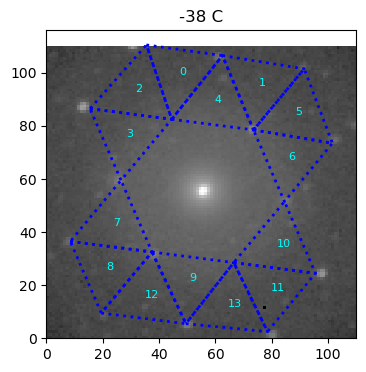

In [30]:
# z=q_stat(30,100,100,'/home/shared/STEM_sample_2/')
z=q_stat(33,180,00,'/home/shared/STEM_sample_2/')
z.visualize_grid(remove_central_shell=True)

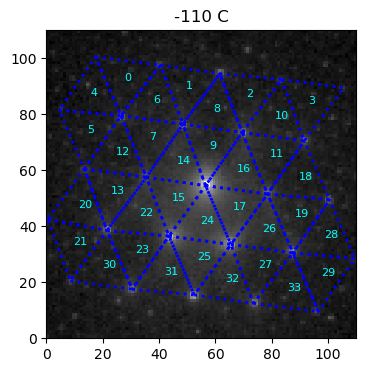

In [ ]:
z=q_stat(0,100,100,'/home/shared/STEM_recal/')
z.visualize_grid()

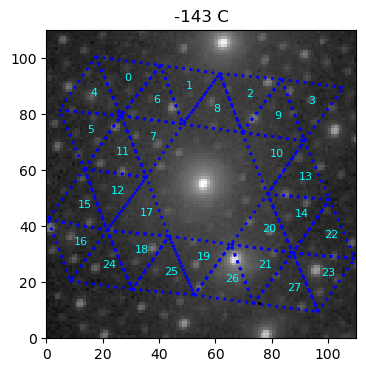

In [71]:
z=q_stat(0,100,100,'/home/shared/STEM_cooling/')
z.visualize_grid(remove_central_shell=True)

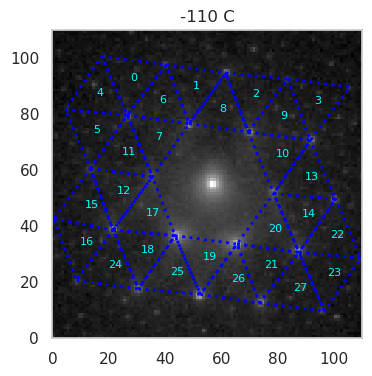

In [ ]:
z=q_stat(0,100,100,'/home/shared/STEM_recal/')
z.visualize_grid(remove_central_shell=True)

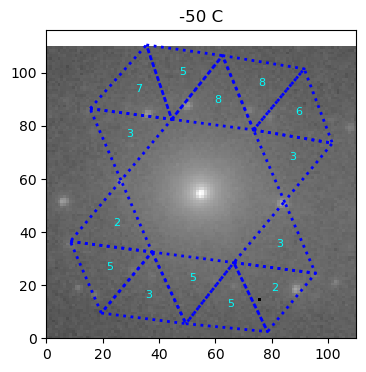

In [43]:
z=q_stat(30,10,10,'/home/shared/STEM_sample_2/',)
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True,color='#00000000')

AttributeError: 'q_stat' object has no attribute 'shape'

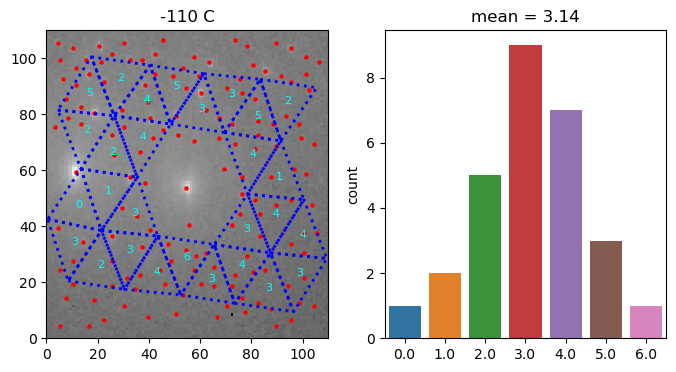

In [ ]:
z=q_stat(0,0,0,'/home/shared/STEM_recal/')
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True)

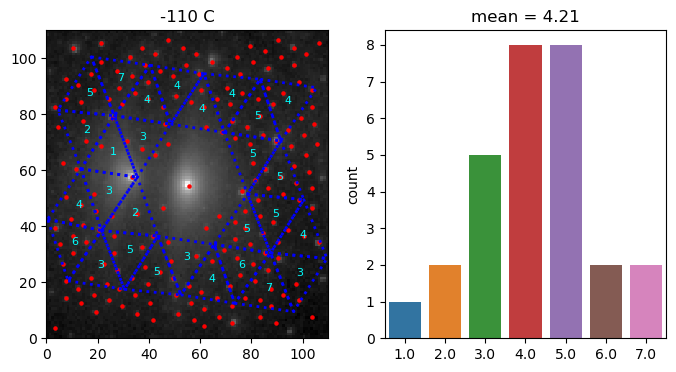

In [ ]:
z=q_stat(0,25,25,'/home/shared/STEM_recal/')
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True)

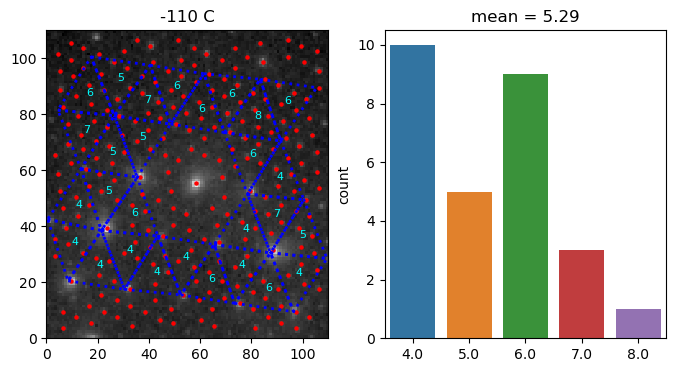

In [18]:
z=q_stat(0,170,160,'/home/shared/STEM_recal/')
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True)

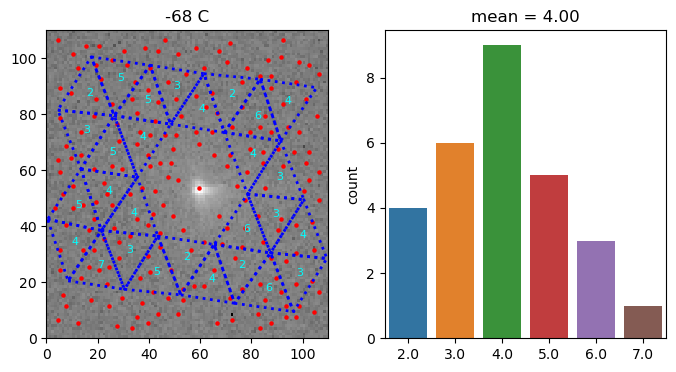

In [3]:
z=q_stat(10,199,199,'/home/shared/STEM_recal/')
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True)

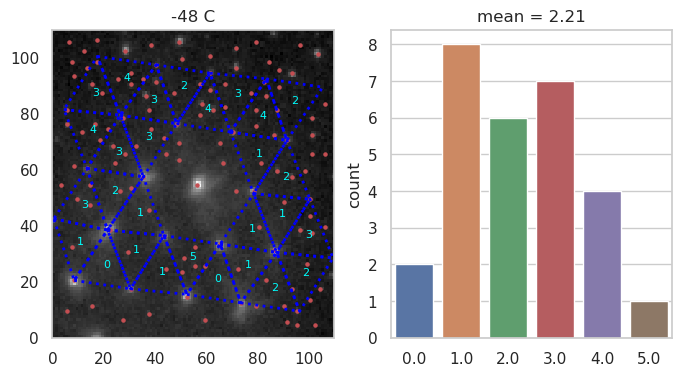

In [56]:
z=q_stat(16,100,100,'/home/shared/STEM_recal/')
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True)

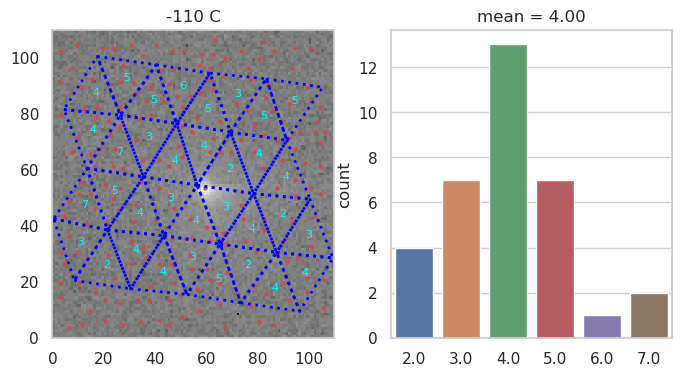

In [59]:
z=q_stat(0,199,199,'/home/shared/STEM_recal/')
occ=z.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=False)

In [ ]:
a1=np.array([51,  78])-np.array([ 54,  56])
a2=np.array([33,  65])-np.array([ 54,  56])
a3=np.array([ 36,  43])-np.array([ 54,  56])

In [ ]:
np.array([ 20,   8])+a2

In [ ]:
np.array([ 92,  83])+a1

In [ ]:
def tri_distance(p1,p2,p3):
    d12=np.linalg.norm(p1-p2)
    d23=np.linalg.norm(p2-p3)
    d13=np.linalg.norm(p3-p1)
    return ([d12,d23,d13]), np.std([d12,d23,d13])

In [ ]:
tri_distance(np.array([ 70,  91]),np.array([ 92,  83]),np.array([ 88, 104]))

In [ ]:
tri_distance(np.array([ 70,  91]),np.array([ 92,  83]),np.array([ 89, 105]))

In [301]:
z=q_stat(10,100,100,'/home/shared/STEM_recal/')

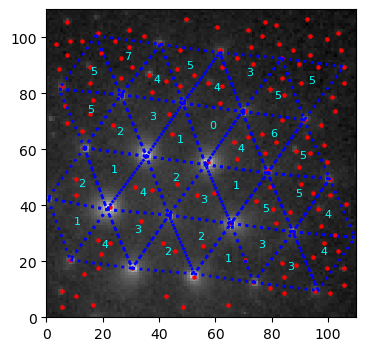

In [302]:
fig,ax=plt.subplots(figsize=(4,4))
ax.pcolormesh(z.logdata,cmap='gray')
# brag_peaks=z.mask_ind[:18]
# ax.scatter(brag_peaks[:,1]+.5,brag_peaks[:,0]+.5,color='y',s=5)

# for (idx,cor) in enumerate(brag_sort):
#     ax.text(cor[1],cor[0],'{}'.format(idx),color='w')

# for key,val in mask_ind_dict.items():
#     ax.text(val[1]-.5,val[0]-.5,'{},{}'.format(key[0],key[1]),color='w')

# for (idx,cor) in enumerate(centroid):
for idx, cor in zip(inside_num, centroid):
    ax.text(cor[1],cor[0],'{:.0f}'.format(idx),color='cyan',fontsize=8)

for triangle in triangle_list:
    pth=np.array(triangle+[triangle[0]])
    ax.plot(pth[:,1]+.5,pth[:,0]+.5,color='blue',lw=2,ls='dotted')

ax.scatter(z.mask_ind[:,1]+.5,z.mask_ind[:,0]+.5,s=5,color='r')
# ax.scatter(cdw_peaks[:,1]+0.5,cdw_peaks[:,0]+0.5,s=5,color='r')
# ax.scatter(bragg_peaks[:,1]+0.5,bragg_peaks[:,0]+0.5,s=5,color='b')
# ax.set_title('{} C'.format(self.T))

In [ ]:
q_stat(0,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=2)

In [ ]:
q_stat(0,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=2)

In [ ]:
q_stat(0,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=2)

In [ ]:
q_stat(9,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=2)

In [ ]:
q_stat(10,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=3)

In [ ]:
q_stat(11,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=3)

In [ ]:
q_stat(12,100,100,'/home/shared/STEM_recal/').all_peaks(return_outlier=True,threshold=3)

In [ ]:
z.remove_bragg()

In [ ]:
z.remove_bragg(remove_outlier=True)

In [ ]:
%lprun -f q_stat._get_bragg_peaks [zz.remove_bragg() for zz in z]

In [ ]:
%lprun -f q_stat._get_bragg_peaks [zz.remove_bragg() for zz in z]

In [ ]:
%lprun -f q_stat._get_bragg_peaks [zz.remove_bragg() for zz in z]

In [ ]:
%lprun -f q_stat.all_peaks [zz.all_peaks() for zz in z]

In [ ]:
%lprun -f q_stat._get_bragg_peaks [zz.remove_bragg() for zz in z]

In [ ]:
%lprun -f z._get_bragg_peaks z.remove_bragg()

In [ ]:
import sklearn

In [ ]:
%lprun -f z.remove_bragg z.remove_bragg()

In [ ]:
z=[q_stat(T_idx,199,199,'/home/shared/STEM_recal/') for T_idx in range(16)]

In [ ]:
all_peaks_mean=[]
all_peaks_std=[]
all_peaks_length=[]
for zz in z:
    results=zz.all_peaks()
    all_peaks_mean.append(results['mean'])
    all_peaks_std.append(results['std'])
    all_peaks_length.append(results['length'])

In [ ]:
all_peaks_outlier_mean=[]
all_peaks_outlier_std=[]
all_peaks_outlier_length=[]
for zz in z:
    results=zz.all_peaks(remove_outlier=True)
    all_peaks_outlier_mean.append(results['mean'])
    all_peaks_outlier_std.append(results['std'])
    all_peaks_outlier_length.append(results['length'])

In [ ]:
remove_bragg_mean=[]
remove_bragg_std=[]
remove_bragg_length=[]
for zz in z:
    results=zz.remove_bragg(remove_outlier=False)
    remove_bragg_mean.append(results['mean'])
    remove_bragg_std.append(results['std'])
    remove_bragg_length.append(results['length'])

In [ ]:
remove_bragg_outlier_mean=[]
remove_bragg_outlier_std=[]
remove_bragg_outlier_length=[]
for zz in z:
    results=zz.remove_bragg(remove_outlier=True)
    remove_bragg_outlier_mean.append(results['mean'])
    remove_bragg_outlier_std.append(results['std'])
    remove_bragg_outlier_length.append(results['length'])

In [ ]:
all_peaks_mean=[]
all_peaks_std=[]
all_peaks_length=[]
for zz in z:
    results=zz.all_peaks()
    all_peaks_mean.append(results['mean'])
    all_peaks_std.append(results['std'])
    all_peaks_length.append(results['length'])

In [ ]:
fig,ax=plt.subplots(4,3,tight_layout=True)
ax[0,0].plot(all_peaks_mean)
ax[0,1].plot(all_peaks_std)
ax[0,2].plot(all_peaks_length)

ax[1,0].plot(all_peaks_outlier_mean)
ax[1,1].plot(all_peaks_outlier_std)
ax[1,2].plot(all_peaks_outlier_length)

ax[2,0].plot(remove_bragg_mean)
ax[2,1].plot(remove_bragg_std)
ax[2,2].plot(remove_bragg_length)

ax[3,0].plot(remove_bragg_outlier_mean)
ax[3,1].plot(remove_bragg_outlier_std)
ax[3,2].plot(remove_bragg_outlier_length)

In [ ]:
fig,ax=plt.subplots(4,3,tight_layout=True)
ax[0,0].plot(all_peaks_mean)
ax[0,1].plot(all_peaks_std)
ax[0,2].plot(all_peaks_length)

ax[1,0].plot(all_peaks_outlier_mean)
ax[1,1].plot(all_peaks_outlier_std)
ax[1,2].plot(all_peaks_outlier_length)

ax[2,0].plot(remove_bragg_mean)
ax[2,1].plot(remove_bragg_std)
ax[2,2].plot(remove_bragg_length)

ax[3,0].plot(remove_bragg_outlier_mean)
ax[3,1].plot(remove_bragg_outlier_std)
ax[3,2].plot(remove_bragg_outlier_length)

## Import from pickle

In [1]:
import pickle

In [ ]:
rs['mean'].shape

In [ ]:
fig,ax=plt.subplots()
ax2=ax.twinx()
ax.plot(rs['T'],rs['mean'][:,100,100],'r')
ax2.plot(rs['T'],rs['std'][:,100,100],'b')
ax.set_ylabel(r'$\overline{q}$',color='r')
ax2.set_ylabel(r'$\sigma_{q}$',color='b')
ax.set_xlabel('T (C)')

#### Clustering real space

##### PCA

In [ ]:
X=q_var_map.reshape((q_var_map.shape[0],-1)).T
X=StandardScaler().fit_transform(X)

pca=PCA(n_components=1)
y=pca.fit_transform(X)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
Y=y.reshape(q_var_map.shape[1:])

In [ ]:
plt.pcolormesh(Y,cmap='gray')
plt.colorbar()

In [ ]:
plt.scatter(*y.T,s=0.1)

##### GMM

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from sklearn.pipeline import Pipeline
import pickle
import pandas as pd
from sklearn.metrics import silhouette_score
class GMM_model:
    def __init__(self,filename,mask=None):
        '''
        rs: (T_idx,x_idx,y_idx)
        mask: ((x_min,x_max),(y_min,y_max))
        '''
        self.filename=filename
        self.mask=mask
        self.rs=self.load()
        self.labels_={}
        self.X_orig={}
        self.X={}
        self.bic={}
        self.silhouette={}

    def load(self):
        with open(self.filename,'rb') as f:
            rs=pickle.load(f)
        if self.mask is not None:
            for key in ['mean','std','length']:
                rs[key]=rs[key][:,self.mask[0][0]:self.mask[0][1],self.mask[1][0]:self.mask[1][1]]
            rs['x']=np.arange(self.mask[0][0],self.mask[0][1])
            rs['y']=np.arange(self.mask[1][0],self.mask[1][1])
        return rs

    def preprocessing(self,kind):
        self.X_orig[kind]=self.rs[kind].reshape((self.rs[kind].shape[0],-1)).T

        # estimators=[('standardize',StandardScaler()),]
        estimators=[('T',FunctionTransformer(lambda x:x.T)),('standardize',StandardScaler()),('T2',FunctionTransformer(lambda x:x.T)),]


        pipeline=Pipeline(estimators)
        self.X[kind]=pipeline.fit_transform(self.X_orig[kind])
        
    def GMM_fit(self,kind,k=3):
        self.preprocessing(kind)
        self.k=k
        self.gm=GaussianMixture(n_components=self.k)

        
    
    def GMM_hypertuning(self,kind,k_range=np.arange(2,7),trial=10):
        self.bic[kind]=pd.DataFrame()
        self.silhouette[kind]=pd.DataFrame()
        if not kind in self.X:
            self.preprocessing(kind)
        for k in k_range:
            bic_k=[]
            silhouette_k=[]
            for i in range(trial):
                print('\r k={} i={}'.format(k,i),end='',flush=True)
                self.GMM_fit(kind,k)
                self.gm.fit(self.X[kind])    
                bic_k.append(self.gm.bic(self.X[kind]))
                silhouette_k.append(silhouette_score(self.X[kind],self.gm.fit_predict(self.X[kind])))
            self.bic[kind][k]=bic_k
            self.silhouette[kind][k]=silhouette_k

    def GMM_plot(self,kind,permutation=None,ax=None):
        self.labels_[kind]=self.gm.fit_predict(self.X[kind])        
        if permutation is None:
            permutation=np.arange(self.k)
        offset=permutation-np.arange(self.k)
        if ax is None:
            fig, ax= plt.subplots(1,3,figsize=(13,4),tight_layout=True)
        cmap = plt.get_cmap('plasma', self.k)
        labels_=self.labels_[kind]
        labels_offset=np.array([offset[labels_[idx]] for idx in range(labels_.shape[0])])
        labels_=labels_+labels_offset
        
        im=ax[0].imshow(labels_.reshape(self.rs[kind].shape[1:]),cmap=cmap,extent=(self.rs['y'][0],self.rs['y'][-1],self.rs['x'][-1],self.rs['x'][0]))
        plt.colorbar(im,ax=ax[0])
        bic_text='BIC={:.0f}, Silhouette={:.2f}'.format(self.gm.bic(self.X[kind]),silhouette_score(self.X[kind],labels_))
        for idx in range(self.k):
            bic_text=bic_text+'\n{}:{}'.format(idx,np.sum(labels_==idx))
        ax[0].set_title(bic_text)
        ax[0].set_xlabel('y')
        ax[0].set_ylabel('x')

        color_list=[cmap(idx) for idx in range(self.k)]
        for n,color in zip(range(4),color_list):
            mean=self.X[kind][labels_==n].T.mean(axis=-1)
            ax[1].plot(self.rs['T'],mean,color=color,label=str(n))
            error=self.X[kind][labels_==n].T.std(axis=-1)
            ax[1].fill_between(self.rs['T'],mean-error,mean+error,color=color,alpha=0.5)
        ax[1].set_xlabel('T (C)')
        ax[1].set_ylabel('z-score of {}'.format(kind))
        ax[1].legend()

        color_list=[cmap(idx) for idx in range(self.k)]
        for n,color in zip(range(4),color_list):
            mean=self.X_orig[kind][labels_==n].T.mean(axis=-1)
            ax[2].plot(self.rs['T'],mean,color=color,label=str(n))
            error=self.X_orig[kind][labels_==n].T.std(axis=-1)
            ax[2].fill_between(self.rs['T'],mean-error,mean+error,color=color,alpha=0.5)
        ax[2].set_xlabel('T (C)')
        ax[2].set_ylabel(kind)
        ax[2].legend()

###### all_peaks_1

In [43]:
all_peaks=GMM_model('q_Txy_all_peaks_1.pickle')

In [ ]:
all_peaks.GMM_hypertuning('mean')
# all_peaks.bic['mean'].boxplot(figsize=(4,3))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks.bic['mean'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks.silhouette['mean'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

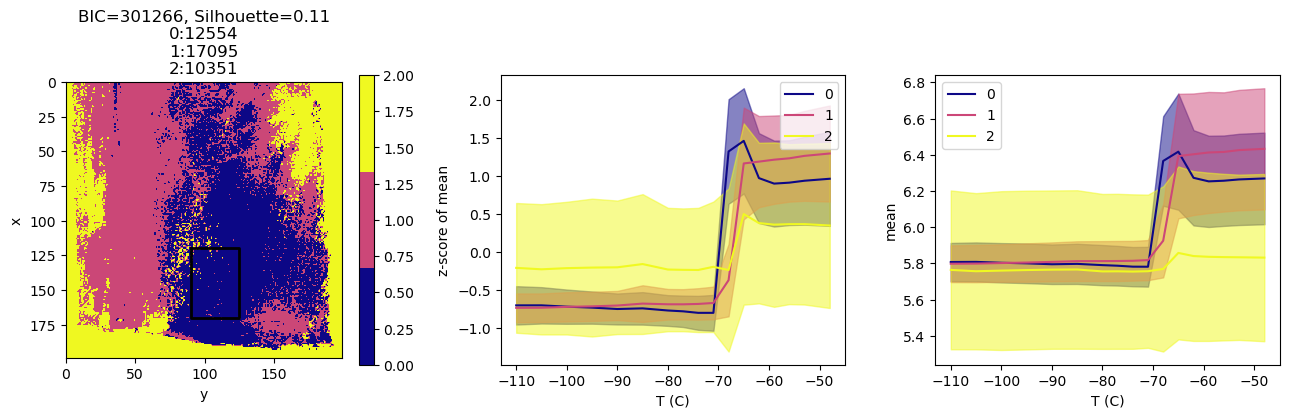

[CV 1/1] END n_components=3; bic: (train=-3141.965, test=-3142.337) silhouette: (train=0.072, test=0.072) total time=   1.1s
[CV 1/1] END n_components=2; bic: (train=-3696.615, test=-3697.064) silhouette: (train=0.081, test=0.081) total time=   1.3s
[CV 1/1] END n_components=5; bic: (train=-1690.378, test=-1583.321) silhouette: (train=0.017, test=0.042) total time=   1.6s
[CV 1/1] END n_components=4; bic: (train=-2466.175, test=-2485.514) silhouette: (train=0.050, test=0.043) total time=   1.3s
[CV 1/1] END n_components=6; bic: (train=-565.025, test=-633.364) silhouette: (train=0.039, test=0.039) total time=   2.3s


In [44]:
all_peaks.GMM_fit('mean',k=3)
fig,axs=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
all_peaks.GMM_plot('mean',ax=axs)

mask=((120,170),(90,125))


axs[0].plot(*np.array([[mask[1][0],mask[0][0]],[mask[1][1],mask[0][0]],[mask[1][1],mask[0][1]],[mask[1][0],mask[0][1]],[mask[1][0],mask[0][0]]]).T,color='k',lw=2)

In [ ]:
all_peaks.GMM_hypertuning('std')
# all_peaks.bic['std'].boxplot(figsize=(4,3))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks.bic['std'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks.silhouette['std'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks.GMM_fit('std',k=3)
all_peaks.GMM_plot('std')

In [ ]:
all_peaks.GMM_hypertuning('length')
# all_peaks.bic['length'].boxplot(figsize=(4,3))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks.bic['length'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks.silhouette['length'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks.GMM_fit('length',k=3)
fig,axs=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
all_peaks.GMM_plot('length',ax=axs)

# mask=((120,170),(50,100))

# axs[0].plot(*np.array([[mask[1][0],mask[0][0]],[mask[1][1],mask[0][0]],[mask[1][1],mask[0][1]],[mask[1][0],mask[0][1]],[mask[1][0],mask[0][0]]]).T,color='k',lw=2)

###### all_peaks_1_outlier

In [ ]:
all_peaks_outlier=GMM_model('q_Txy_all_peaks_outlier_1.pickle')

In [ ]:
all_peaks_outlier.GMM_hypertuning('mean')
# all_peaks_outlier.bic['mean'].boxplot(figsize=(4,3))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_outlier.bic['mean'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_outlier.silhouette['mean'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
# all_peaks_outlier.GMM_fit('mean',k=3)
all_peaks_outlier.GMM_plot('mean',[0,1,2])

In [ ]:
all_peaks_outlier.GMM_hypertuning('std')
# all_peaks_outlier.bic['std'].boxplot(figsize=(4,3))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_outlier.bic['std'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_outlier.silhouette['std'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_outlier.GMM_fit('std',k=3)
all_peaks_outlier.GMM_plot('std',[1,0,2])

In [ ]:
all_peaks_outlier.GMM_hypertuning('length')
# all_peaks_outlier.bic['length'].boxplot(figsize=(4,3))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_outlier.bic['length'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_outlier.silhouette['length'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_outlier.GMM_fit('length',k=3)
all_peaks_outlier.GMM_plot('length')

###### all_peaks_1_outlier_thrs_3

In [ ]:
all_peaks_outlier_thrs_3=GMM_model('q_Txy_all_peaks_outlier_thrs_3.pickle')

In [ ]:
all_peaks_outlier_thrs_3.GMM_hypertuning('mean')

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_outlier_thrs_3.bic['mean'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_outlier_thrs_3.silhouette['mean'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_outlier_thrs_3.GMM_fit('mean')
all_peaks_outlier_thrs_3.GMM_plot('mean')

In [ ]:
all_peaks_outlier_thrs_3.GMM_hypertuning('std')

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_outlier_thrs_3.bic['std'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_outlier_thrs_3.silhouette['std'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_outlier_thrs_3.GMM_fit('std')
all_peaks_outlier_thrs_3.GMM_plot('std')

In [ ]:
all_peaks_outlier_thrs_3.GMM_hypertuning('length')

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_outlier_thrs_3.bic['length'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_outlier_thrs_3.silhouette['length'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_outlier_thrs_3.GMM_fit('length')
all_peaks_outlier_thrs_3.GMM_plot('length')

###### no_bragg_peaks_1

In [ ]:
remove_bragg=GMM_model('q_Txy_remove_bragg_1.pickle')

In [ ]:
# remove_bragg.GMM_fit('mean')
remove_bragg.GMM_plot('mean')

In [ ]:
remove_bragg.GMM_fit('std')
remove_bragg.GMM_plot('std')

In [ ]:
# remove_bragg.GMM_fit('length')
remove_bragg.GMM_plot('length',[2,0,1])

###### no_bragg_peaks_1_outlier

In [ ]:
remove_bragg_outlier=GMM_model('q_Txy_remove_bragg_outlier_1.pickle')

In [ ]:
remove_bragg_outlier.GMM_fit('mean')
remove_bragg_outlier.GMM_plot('mean')

In [ ]:
# remove_bragg_outlier.GMM_fit('std')
remove_bragg_outlier.GMM_plot('std',[2,0,1])

In [ ]:
# remove_bragg_outlier.GMM_fit('length')
remove_bragg_outlier.GMM_plot('length',[0,2,1])

###### all_peaks_2

In [ ]:
all_peaks_2=GMM_model('q_Txy_all_peaks_2.pickle')

In [ ]:
all_peaks_2.GMM_fit('mean')
all_peaks_2.GMM_plot('mean')

In [ ]:
# all_peaks_2.GMM_fit('std')
all_peaks_2.GMM_plot('std',[1,0,2])

In [ ]:
all_peaks_2.GMM_fit('length')
all_peaks_2.GMM_plot('length')

###### all_peaks_outlier_2

In [ ]:
all_peaks_outlier_2=GMM_model('q_Txy_all_peaks_outlier_2.pickle')

In [ ]:
# all_peaks_outlier_2.GMM_fit('mean')
all_peaks_outlier_2.GMM_plot('mean',[2,0,1])

In [ ]:
all_peaks_outlier_2.GMM_fit('std')
all_peaks_outlier_2.GMM_plot('std')

In [ ]:
# all_peaks_outlier_2.GMM_fit('length')
all_peaks_outlier_2.GMM_plot('length',[0,2,1])

###### no_bragg_peaks_2

In [ ]:
remove_bragg_2=GMM_model('q_Txy_remove_bragg_2.pickle')

In [ ]:
remove_bragg_2.GMM_fit('mean')
remove_bragg_2.GMM_plot('mean')

In [ ]:
remove_bragg_2.GMM_fit('std')
remove_bragg_2.GMM_plot('std')

In [ ]:
remove_bragg_2.GMM_fit('length')
remove_bragg_2.GMM_plot('length')

###### no_bragg_peaks_outlier_2

In [ ]:
remove_bragg_outlier_2=GMM_model('q_Txy_remove_bragg_outlier_2.pickle')

In [ ]:
remove_bragg_outlier_2.GMM_fit('mean')
remove_bragg_outlier_2.GMM_plot('mean')

In [ ]:
remove_bragg_outlier_2.GMM_fit('std')
remove_bragg_outlier_2.GMM_plot('std')

In [ ]:
remove_bragg_outlier_2.GMM_fit('length')
remove_bragg_outlier_2.GMM_plot('length')

##### Homogeneous region

In [6]:
mask=((125,75),(90,125))

In [5]:
all_peaks_subset=GMM_model('q_Txy_all_peaks_1.pickle',mask=mask)

NameError: name 'GMM_model' is not defined

In [ ]:
all_peaks_subset.GMM_hypertuning('mean',trial=5,k_range=np.arange(2,6))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_subset.bic['mean'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_subset.silhouette['mean'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_subset.GMM_fit('mean',k=3)
all_peaks_subset.GMM_plot('mean')

In [ ]:
all_peaks_subset.GMM_hypertuning('length',trial=10,k_range=np.arange(2,6))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_subset.bic['length'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_subset.silhouette['length'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_subset.GMM_fit('length',k=3)
all_peaks_subset.GMM_plot('length')

In [ ]:
mask=((120,170),(50,100))
all_peaks_subset=GMM_model('q_Txy_all_peaks_1.pickle',mask=mask)

In [ ]:
all_peaks_subset.GMM_hypertuning('length',trial=10,k_range=np.arange(2,6))

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(6,3),tight_layout=True)
all_peaks_subset.bic['length'].boxplot(figsize=(4,3),ax=axs[0])
all_peaks_subset.silhouette['length'].boxplot(figsize=(4,3),ax=axs[1])
[ax.set_xlabel('k') for ax in axs]
axs[0].set_ylabel('BIC')
axs[1].set_ylabel('Silhouette Score')

In [ ]:
all_peaks_subset.GMM_fit('length',k=3)
all_peaks_subset.GMM_plot('length')

##### count_pts

In [2]:
count_pts=GMM_model('q_Txy_count_pts_count_pts.pickle',)

In [ ]:
count_pts.GMM_hypertuning('mean')

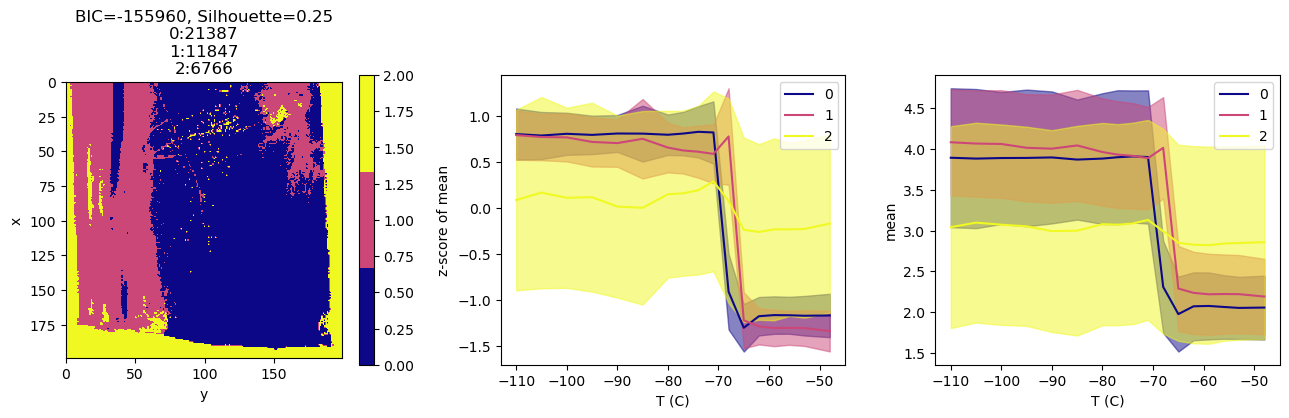

In [3]:
count_pts.GMM_fit('mean',k=3)
fig,axs=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts.GMM_plot('mean',ax=axs)

In [ ]:
count_pts.GMM_hypertuning('std')

In [ ]:
count_pts.GMM_fit('std',k=3)
fig,axs=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts.GMM_plot('std',ax=axs)

(17, 200, 200)

##### count_pts_outlier

In [17]:
count_pts_outlier=GMM_model('q_Txy_count_pts_outlier_count_pts.pickle',)

In [ ]:
count_pts_outlier.GMM_hypertuning('mean')

In [ ]:
count_pts_outlier.GMM_fit('mean',k=3)
fig,axs=plt.subplots(1,3,figsize=(13,4),tight_layout=True)
count_pts_outlier.GMM_plot('mean',ax=axs)

##### tuning n_components

In [ ]:
n_components_range = range(2, 10)
bic=[]
for n_components in n_components_range:
    gm=GaussianMixture(n_components=n_components)
    gm.fit(X)
    bic.append(gm.bic(X))


In [ ]:
plt.plot(n_components_range,bic)
plt.xticks(n_components_range)
plt.grid('on')

In [ ]:
n_components_range[np.argmin(bic)]

#### kMeans

In [ ]:
clustering=DBSCAN()

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f q_stat_para list(map(q_stat_para,para_list))

In [ ]:
for result in results:
    eta,r,delta,MI1,delta_i,L_i=result
    r_list[L_i,delta_i]=r
    delta0_list[L_i,delta_i]=delta
    eta_list[L_i,delta_i]=eta
    MI1_map[L_i,delta_i,:]=MI1
MI1_list=MI1_map.mean(axis=2)

In [ ]:
for x in range(30,I.shape[1]-30) for y in range(30,I.shape[2]-30)

## Test

In [ ]:
x=np.exp(x)

In [ ]:
z=(x-x.mean())/x.std()

In [ ]:
plt.hist(x)

In [ ]:
plt.hist(z)

In [ ]:
z.std()

## Sweep thresdhold

In [ ]:
thres_list=np.linspace(0.4,.99,21)

In [ ]:
mask_ind=peak_local_max(np.log10(data),threshold_rel=0,min_distance=3)

In [ ]:
mask_ind.shape

In [ ]:
mask_list=[peak_local_max(np.log10(data),indices=False,threshold_rel=thres,min_distance=1) for thres in thres_list]

In [ ]:
porp=[m.sum()/np.prod(data.shape) for m in mask_list]

In [ ]:
thres_list[np.abs(porp-porp[0]/2).argmin()]

In [ ]:
plt.plot(thres_list,porp)

In [ ]:
mask=peak_local_max(data,indices=False)

In [ ]:
idx[0]

In [ ]:
data[54,56]

In [ ]:
data[tuple(idx[0])]

In [ ]:
data_peak=[data[tuple(ind)] for ind in idx]

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
T_idx=0
# vmin,vmax=I[:,x,y].min(),I[:,x,y].max()
im=ax.scatter(xmesh_masked,ymesh_masked,c=data_masked,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# im=ax.scatter(idx[:,1],idx[:,0],c=data_peak,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# im=ax.tripcolor(xmesh_masked,ymesh_masked,data_masked,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title('I')
# ax.scatter(55,55)


In [ ]:
def animate(i):
    data=I[i,x,y,:,:]
    im.set_array(data.ravel())
    tit.set_text('T={:d} C'.format(T[i]))
    return im,tit

In [ ]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0],blit=True,repeat=True)
anim.save('movie.mp4',dpi=300)

# get threshold

In [ ]:
from scipy import signal
from scipy import misc

In [ ]:
x,y=100,100
I_pos=I[:-1,x,y,:,:]

In [ ]:
I_pos.shape

In [ ]:
I_pos[[0]].min()

In [ ]:
masked    = Mask_Zeros(I_pos) 
threshold = Threshold_Background(masked)
Thresh_cutoff=threshold.LogI_cutoff


In [ ]:
masked.zero_mask.sum()

In [ ]:
threshold.LogI_cutoff

In [ ]:
print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', threshold.data_thresholded.shape[1])
print('cutoff=', Thresh_cutoff)

In [ ]:
Data_thresh     = threshold.data_thresholded  # shape=(num_temperatures, num_thresholded data)
Data_ind        = threshold.ind_thresholded           # contains hkl indices of the thresholded data.

In [ ]:
Data_thresh

In [ ]:
Data_ind

In [ ]:
# I_pos=I[:-1,x,y,:,:]
drop=-1
conv_size=3
# I_pos=0
# cc=np.ones((conv_size,conv_size))
# cc=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=float)
xx,yy=np.meshgrid((np.arange(conv_size)-conv_size//2),(np.arange(conv_size)-conv_size//2))
sigma=2
cc=np.exp((-xx**2-yy**2)/sigma**2)
cc/=cc.sum()
I_pos=np.array([signal.convolve2d(i,cc,boundary='fill') for i in I[:drop,x,y]])[:,conv_size//2:I.shape[3]-conv_size//2,conv_size//2:I.shape[4]-conv_size//2]
# I_pos+=I[:drop,x,y,max(0,i):min(I.shape[3],i),max(0,j):min(I.shape[4],j)]
# I_pos/=len(ij_list)
# I_pos=(I[:drop,x,y,offset:,offset:]+I[:drop,x,y,:-offset,:-offset]+I[:drop,x,y,offset:,:-offset]+I[:drop,x,y,:-offset,offset:])/4

In [ ]:
I[0,x,y].shape

In [ ]:
I_pos.shape

In [ ]:
masked    = Mask_Zeros(I_pos) 
threshold = Threshold_Background(masked)
Thresh_cutoff=threshold.LogI_cutoff
print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', threshold.data_thresholded.shape[1])
print('cutoff=', Thresh_cutoff)

In [ ]:
threshold.plot_cutoff((10,5))

In [ ]:
Data_thresh     = threshold.data_thresholded  # shape=(num_temperatures, num_thresholded data)
Data_ind        = threshold.ind_thresholded           # contains hkl indices of the thresholded data.

print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', Data_thresh.shape[1])

In [ ]:
Data_thresh.shape

In [ ]:
Data_ind

In [ ]:
plt.scatter(Data_ind[:,0],Data_ind[:,1],c=Data_thresh)

# Clustering

In [ ]:
Tlist=T[:drop]
x_train = np.array(Tlist)
data_post_thresh = Data_thresh
Rescaled_data  = (data_post_thresh/np.mean(data_post_thresh,axis=0)-1) 
# Rescaled_data = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(np.mean(data_post_thresh,axis=0)) 

y_train=Rescaled_data.transpose() 
print('Data shape: (num_data, num_T)=',y_train.shape)

In [ ]:
num_clusters = 2
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

In [ ]:
plotting_slice = threshold.thresholded.copy()
for k in range(num_clusters):
    cluster_mask = clusterGMM.cluster_assignments == k
    cluster_ind = Data_ind[cluster_mask]
    plotting_slice[cluster_ind[:, 0], cluster_ind[:, 1]] = k + 2
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)
fig=plt.figure(figsize=(20,20))


plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

In [ ]:
Bad_Clusters=[0,] # Select the list clusters to be removed: 0 for Red, 1 for blue, 2 for green, 3 for violet, 4 for yellow, 5 for orange, 6 for pink clusters...
# Note that the color assignments can change with each run.


# This block removes the data belonging to the bad clusters from the first clustering  
cluster_assignments = clusterGMM.cluster_assignments 
BadC_mask           = ~np.isin(cluster_assignments, Bad_Clusters)

Good_data              = Data_thresh[:,BadC_mask] 
Good_rescaled_data     = Rescaled_data[:,BadC_mask]   # the rescaled data belonging to the good clusters
Good_ind               = Data_ind[BadC_mask]          # (h,k,l) indices of the good data

In [ ]:
x_train = np.array(Tlist)


y_train=Good_rescaled_data.transpose() 

print('Data shape: (num_data, num_T)=',y_train.shape)


num_clusters = 2
clusterGMM_1 = GMM(y_train,num_clusters)
clusterGMM_1.RunEM()
print('Num per cluster',clusterGMM_1.num_per_cluster)
clusterGMM_1.Plot_Cluster_Results_traj(x_train)

In [ ]:
plotting_slice = threshold.thresholded.copy()



for k in range(num_clusters):
    cluster_mask = clusterGMM_1.cluster_assignments == k
    cluster_ind = Good_ind[cluster_mask]
    plotting_slice[cluster_ind[:, 0], cluster_ind[:, 1]] = k + 2
            
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)




fig=plt.figure(figsize=(20,20))


plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

    

# Draft

In [ ]:
fn_list=os.listdir(workingdir)

In [ ]:
def get_temp(fn):
    return int(re.search(r'.*(?=C)',fn).group(0))

In [ ]:
temp_list=[get_temp(fn) for fn in fn_list]

In [ ]:
temp_list_sorted,fn_list_sorted=zip(*sorted(zip(temp_list,fn_list)))

In [ ]:
z2=np.load(workingdir+fn_list_sorted[-1])

In [ ]:
fig,ax=plt.subplots()
data=z2[100,100,:,:]
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [ ]:
import psutil

In [ ]:
psutil.Process().memory_info().rss / (1024 * 1024*1024)

In [ ]:
gc.collect()

In [ ]:
import dask.array as da


In [ ]:

data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))

In [ ]:
a[0,0].compute()

In [ ]:
b = a.max(axis=1)[::-1] + 10

In [ ]:
import graphviz

In [ ]:
b.visualize()

In [ ]:
x = da.ones((1000000, 1000000), chunks=(1000, 1000))

In [ ]:
x

In [ ]:
zz=dask.array.from_npy_stack(workingdir)

In [ ]:
d1 = np.random.random(size = (1000,20))
d2 = np.random.random(size = (1000,1000))

In [ ]:
import h5py

In [ ]:
hf = h5py.File('data.hdf5', 'w')

hf.create_dataset('dataset_1', data=d1, compression="gzip", compression_opts=9)
hf.create_dataset('dataset_2', data=d2, compression="gzip", compression_opts=9)

hf.close()

In [ ]:
np.save('data.npy',d2)

In [ ]:
hf2 = h5py.File('data.hdf5', 'r')

In [ ]:
[x for x in hf2.keys()]

In [ ]:
list(hf2.keys())

In [ ]:
f = h5py.File('test.h5', 'w')

In [ ]:
arr = f.create_dataset('T', (len(fn_list_sorted),*z2.shape), chunks=True,compression="gzip", compression_opts=9)

In [ ]:
arr[0]=z2

In [ ]:
f.close()

In [ ]:
arr

In [ ]:
hf = h5py.File('data.hdf5', 'w')

for fn in 

In [ ]:
hf2.close()

In [ ]:
psutil.Process().memory_info().rss / (1024 * 1024*1024)

In [ ]:
gc.collect()

In [ ]:
del tmp

In [ ]:
I=[]
for fn in fn_list_sorted:
    print('before load {}={:.2f} GB'.format(fn,psutil.Process().memory_info().rss / (1024 * 1024*1024)))
    tmp=np.load(workingdir+fn_list_sorted[0])
    I.append(tmp[100,100])
    print('after load={:.2f}GB'.format(psutil.Process().memory_info().rss / (1024 * 1024*1024)))
    del tmp

In [ ]:
def single_position(x,y):
    
    I=[]
    for fn in fn_list_sorted:
        print('before load {}={:.2f} GB'.format(fn,psutil.Process().memory_info().rss / (1024 * 1024*1024)))
        tmp=np.load(workingdir+fn_list_sorted[0])
        I.append(tmp[x,y])
        print('after load={:.2f}GB'.format(psutil.Process().memory_info().rss / (1024 * 1024*1024)))
        del tmp
    return np.array(I)

In [ ]:
I.shape

In [ ]:
fig,ax=plt.subplots()
ax.pcolor(I[0],cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [ ]:
z2.shape

In [ ]:
z2[100,100].max(),z2[100,100].min()

In [ ]:
import matplotlib.colors as colors

In [ ]:
fig,ax=plt.subplots()
data=z2[150,150]
ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [ ]:
fig,ax=plt.subplots()
data=z2[120,120]
ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [ ]:
from matplotlib.animation import FuncAnimation


In [ ]:
fig,ax=plt.subplots()
ax.pcolormesh(z2[:,:,50:60,15:25].sum(axis=(2,3)),cmap='gray')

In [ ]:
z2.shape

In [ ]:
z.shape[0]